# Lecture 37: Enhancing Nearest Neighbor

In [1]:
from datascience import *
import numpy as np

import matplotlib.pyplot as plots
from mpl_toolkits.mplot3d import Axes3D
plots.style.use('fivethirtyeight')
%matplotlib inline
np.set_printoptions(legacy='1.13')

NUM_REPETITIONS = 5

## Nearest neighbor classifier

In [2]:
raw_ckd = Table.read_table('ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
    
def ckd_label(number):
    if number == 0:
        return "notckd"
    elif number == 1:
        return "ckd"
    else:
        return "unknown"
  
ckd = raw_ckd.with_column(
    'Class', raw_ckd.apply(ckd_label, 'Class')
)    
ckd.show(3)

Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Glucose,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
53,90,1.02,2,0,abnormal,abnormal,present,notpresent,70,107,7.2,114,3.7,9.5,29,12100,3.7,yes,yes,no,poor,no,yes,ckd
63,70,1.01,3,0,abnormal,abnormal,present,notpresent,380,60,2.7,131,4.2,10.8,32,4500,3.8,yes,yes,no,poor,yes,no,ckd


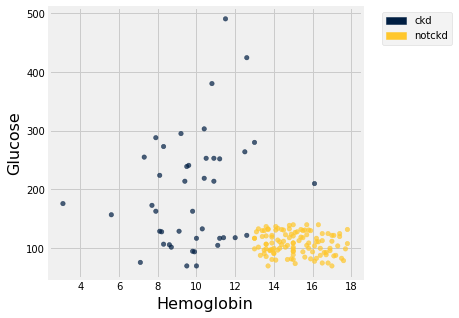

In [3]:
hgb_glc = ckd.select('Hemoglobin', 'Glucose', 'Class')
hgb_glc.scatter('Hemoglobin', 'Glucose', colors='Class')

**Code for the classifier.**

10 functions, 105 lines of code

In [4]:
def standard_units(array):
    """Convert array to standard units.
    """
    return (array - array.mean()) / array.std()
    
def standardize(t):
    """Convert table t to standard units.
    """
    su = Table()
    for label in t.labels:
        su = su.with_column(
            label + ' (su)', standard_units(t.column(label))
        )
    return su

def convert_table_with_classes_to_su(table):
    """Convert table to standard units.  The last column
    of the table is assumed to be a non-quantitative 
    variable (i.e., a class) that should not be standardized.
    """
    last_column_index = table.num_columns - 1
    table_without_classes = table.drop(last_column_index)
    table_without_classes_su = standardize(table_without_classes)
    classes = table.column(last_column_index)

    table_su = table_without_classes_su.with_column(
        np.array(table.labels).item(last_column_index), classes
    )

    return table_su

def in_su(value, array):
    """Return value in standard units according to 
    the distribution of array.
    """
    return (value - array.mean()) / array.std()

def new_point_in_su(new_point, table):
    """Return the new point, with all its coordinates converted
    to standard units, according to the distribution given by
    the table.  The first element of the new_point array 
    corresponds to the first column of the table, and so forth.
    If the table has extra columns, they will be ignored.
    """
    new_point_su = make_array()
    num_dimensions = len(new_point)
    for i in np.arange(num_dimensions):
        coord_su = in_su(new_point.item(i), table.column(i))
        new_point_su = np.append(new_point_su, coord_su)
    return new_point_su

def distance(a, b):
    """Returns the distance between a and b, where a and b
    are both arrays representing points.
    """
    return np.sqrt(np.sum((a - b)**2))

def all_distances(new_point, table):
    """Returns a table with two columns labeled Distance and Class.  
    The first column contains the distance from new_point to each 
    point in table.  The second column contains the label of the 
    corresponding point in table.  The classes should be in the 
    final column of table.  The table that is returned is sorted in 
    ascending order by Distance.
    """

    def distance_from_new(row):
        """Return the distance between row and new_point.
        """
        return distance(np.array(row), new_point)

    last_column_index = table.num_columns - 1
    table_without_classes = table.drop(last_column_index)
    classes = table.column(last_column_index)
    
    distances = Table().with_columns(
        'Distance', table_without_classes.apply(distance_from_new),
        'Class', classes
    ).sort('Distance')

    return distances

def train_nn_su_classifier(train):
    """Create a nearest-neighbor classifier.  The last column 
    of the training table should be the labels, and the preceeding
    columns should be the attributes.  The names of the columns do not
    matter.  The classifier will work in standard units; but,
    the training table should be in original units.
    
    Returns a function.  That function takes as input a 
    new point in original units. The function returns the 
    classification of the new point as output.
    """
    
    train_su = convert_table_with_classes_to_su(train)
    
    def classify_new_point(new_point):
        """Return the classification of new_point, which
        should still be in original units.
        """
        new_point_su = new_point_in_su(new_point, train)
        distances = all_distances(new_point_su, train_su)
        return distances.column('Class').item(0)
    
    return classify_new_point

**Q:** What is the type of `train_nn_su_classifier`?

A.  a number  
B.  an array  
C.  a table  
D.  a function  
E.  none of the above  

In [5]:
type(train_nn_su_classifier)

function

**Q:** What is the type of `train_nn_su_classifier(hgb_glc)`?

A.  a number  
B.  an array  
C.  a table  
D.  a function  
E.  none of the above  

In [6]:
type(train_nn_su_classifier(hgb_glc))

function

**Q:** What is the type of `train_nn_su_classifier(hgb_glc)(make_array(15, 130))`?

A.  a number  
B.  an array  
C.  a table  
D.  a function  
E.  none of the above  

In [7]:
type(train_nn_su_classifier(hgb_glc)(make_array(15, 130)))

str

In [8]:
classifier = train_nn_su_classifier(hgb_glc)
label = classifier(make_array(15, 130))
label

'notckd'

**Functions to analyze classifier accuracy.**

In [9]:
def visualize_boundary(known_points, classifier, x_range, y_range):
    """Visualize the boundary region of a classifier.
    The visualization is in original units."""
    decisions = Table(known_points.labels)
    for x in x_range:
        for y in y_range:
            predicted = classifier(make_array(x, y))
            decisions.append([x, y, predicted])
    decisions.scatter(0, 1, colors='Class', alpha=0.4)
    plots.xlim(x_range.min(), x_range.max())
    plots.ylim(y_range.min(), y_range.max())
    notckd_pts = known_points.where('Class', 'notckd')
    ckd_pts = known_points.where('Class', 'ckd')
    plots.scatter(notckd_pts.column(0), notckd_pts.column(1), c='gold', edgecolor='k');
    plots.scatter(ckd_pts.column(0), ckd_pts.column(1), c='darkblue', edgecolor='k');

def classifier_accuracy(test, classifier):
    """Evaluate the accuracy of the classifier using the
    provided test table, whose last column should be
    the labels.  The names of the columns are irrelevant."""
    
    last_column = test.num_columns - 1
    actual_labels = test.column(last_column)
    predicted_labels = test.drop(last_column).apply(classifier)
    
    return np.mean(actual_labels == predicted_labels) 

def histogram_nn_classifier_accuracy(data, classifier_trainer, num_repetitions=NUM_REPETITIONS):
    """Visualize the empirical distribution of the accuracy
    of a classifier.  The data input is a table that will
    be split into test and training tables for each iteration
    The classifier_trainer is a function that takes a training 
    table as input, and returns a classifier function.  That 
    classifier function itself should take a new point as input 
    and return the classification of that point."""

    accuracies = make_array()
    
    for _ in np.arange(num_repetitions):
        half = int(data.num_rows / 2)
        train, test = data.split(half) 
        
        trained_classifier = classifier_trainer(train)
        acc = classifier_accuracy(test, trained_classifier)
        accuracies = np.append(accuracies, acc)
    
    Table().with_column(
        'Accuracy', accuracies
    ).hist()


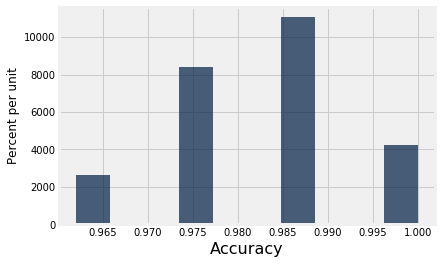

In [10]:
histogram_nn_classifier_accuracy(hgb_glc, train_nn_su_classifier, num_repetitions=50)

## Majority Voting in a Neighborhood

Back to a pair of variables where it was harder to classify...

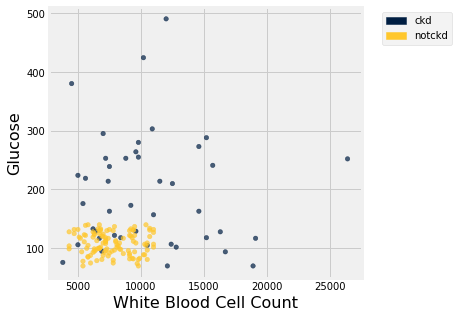

In [11]:
ckd.scatter('White Blood Cell Count', 'Glucose', colors='Class')

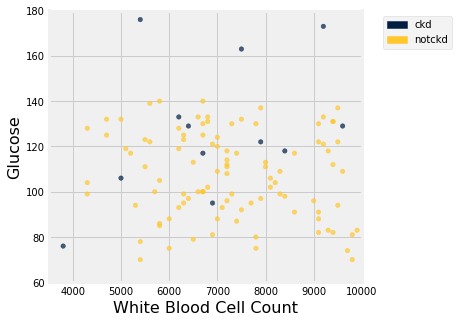

In [12]:
ckd.scatter('White Blood Cell Count', 'Glucose', colors='Class')
plots.xlim(3500,10000);
plots.ylim(60,180);

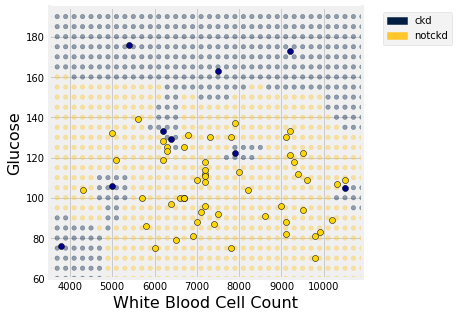

In [13]:
wbc_glc = ckd.select('White Blood Cell Count', 'Glucose', 'Class')
half = int(wbc_glc.num_rows / 2)
train_wbc_glc, test_wbc_glc = wbc_glc.split(half)
wbc_glc_scaled_classifier = train_nn_su_classifier(train_wbc_glc)
visualize_boundary(train_wbc_glc, wbc_glc_scaled_classifier,
                  np.arange(3500,11000,200), np.arange(60,200,5))

**Q:** How many points are being mis-classified here?

A. 0  
B. 1  
C. 2 or more  

In [14]:
classifier_accuracy(train_wbc_glc, wbc_glc_scaled_classifier)

1.0

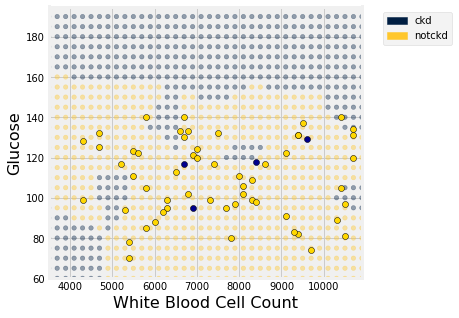

In [15]:
visualize_boundary(test_wbc_glc, wbc_glc_scaled_classifier,
                  np.arange(3500,11000,200), np.arange(60,200,5))

**Q:** How many points are being mis-classified here?

A. 0  
B. 1  
C. 2 or more  

In [16]:
classifier_accuracy(test_wbc_glc, wbc_glc_scaled_classifier)

0.87341772151898733

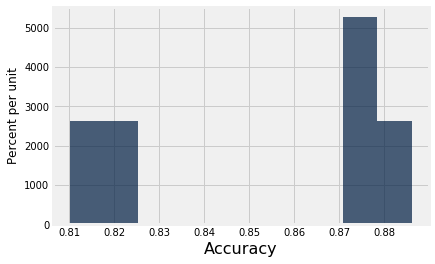

In [17]:
histogram_nn_classifier_accuracy(wbc_glc, train_nn_su_classifier)

In [18]:
def most_frequent_value(array):
    """Returns the value of array that occurs most frequently.
    """
    t = Table().with_column('values', array)
    counts = t.group('values').sort('count', descending=True).column('values')
    return counts.item(0)

In [19]:
most_frequent_value(make_array(1,1,1,0,0,0,0,0))

0

In [20]:
def train_knn_su_classifier(train, k):
    """Create a k-nearest-neighbor classifier.  The last column 
    of the training table should be the labels, and the preceeding
    column should be the attributes.  The names of the columns do not
    matter.  The classifier will work in standard units; but,
    the training table should be in original units.    
    
    Returns a function.  That function takes as input a 
    new point, which should be an array with two items,
    the x and y value of the new point, in that order,
    in original units. The function returns the 
    classification of the new point as output."""

    train_su = convert_table_with_classes_to_su(train)
    
    def classify_new_point(new_point):
        """Return the classification of new_point, which
        should still be in original units.
        """
        new_point_su = new_point_in_su(new_point, train)
        distances = all_distances(new_point_su, train_su)
        top_k = distances.take(np.arange(k)).column('Class')
        return most_frequent_value(top_k)
    
    return classify_new_point


In [21]:
def train_and_visualize_wbc_glc(k):
    classifier = train_knn_su_classifier(train_wbc_glc, k)
    visualize_boundary(test_wbc_glc, classifier,
                  np.arange(3500,11000,250), np.arange(60,200,10))
    acc = classifier_accuracy(test_wbc_glc, classifier)
    print('Accuracy:', acc)

Accuracy: 0.873417721519


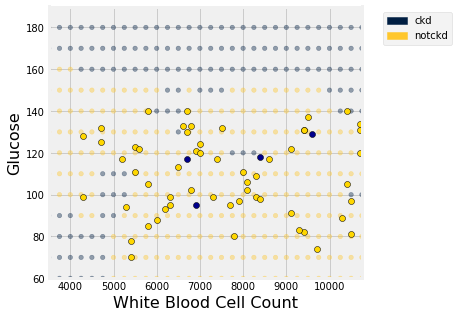

In [22]:
train_and_visualize_wbc_glc(1)

Accuracy: 0.911392405063


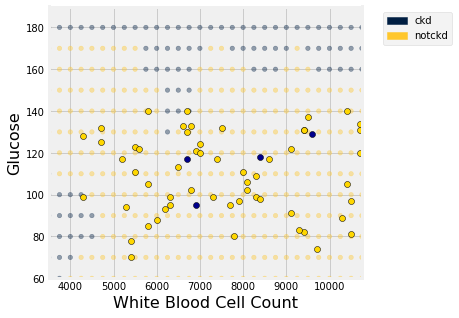

In [23]:
train_and_visualize_wbc_glc(3)

Accuracy: 0.949367088608


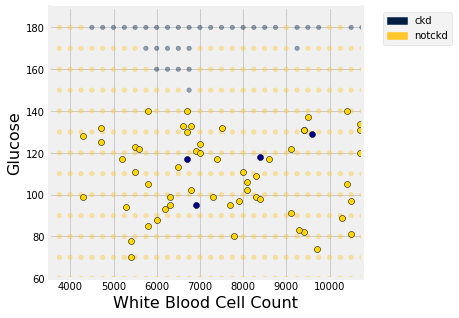

In [24]:
train_and_visualize_wbc_glc(5)

In [25]:
def histogram_knn_classifier_accuracy(data, classifier_trainer, k=5, num_repetitions=NUM_REPETITIONS):
    """Visualize the empirical distribution of the accuracy
    of a classifier.  The data input is a table that will
    be split into test and training tables for each iteration
    The classifier_trainer is a function that takes a training 
    table as input, and returns a classifier function.  That 
    classifier function itself should take a new point as input 
    and return the classification of that point."""

    accuracies = make_array()
    
    for _ in np.arange(num_repetitions):
        half = int(data.num_rows / 2)
        train, test = data.split(half)
        
        trained_classifier = classifier_trainer(train, k)
        acc = classifier_accuracy(test, trained_classifier)
        accuracies = np.append(accuracies, acc)
    
    Table().with_column(
        'Accuracy', accuracies
    ).hist()

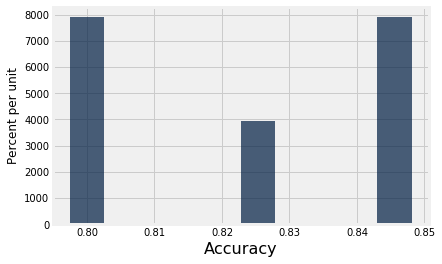

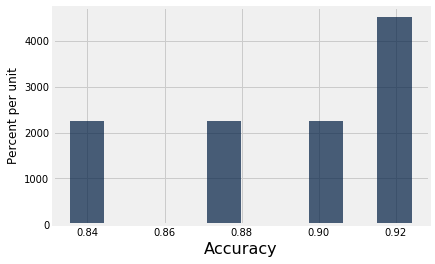

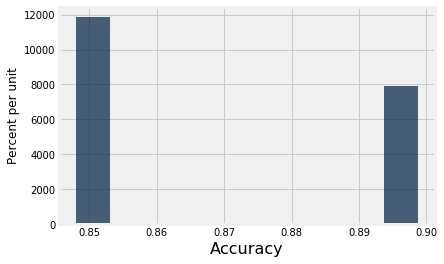

In [26]:
for k in make_array(1,3,5):
    histogram_knn_classifier_accuracy(wbc_glc, train_knn_su_classifier, k)

## Classification with multiple attributes

With CKD we could find one pair of attributes with a clean separation boundary.  What if we couldn't?

In [27]:
# Source: https://archive.ics.uci.edu/ml/datasets/banknote+authentication
banknotes = Table.read_table('banknote.csv')
banknotes

WaveletVar,WaveletSkew,WaveletCurt,Entropy,Class
3.6216,8.6661,-2.8073,-0.44699,0
4.5459,8.1674,-2.4586,-1.4621,0
3.866,-2.6383,1.9242,0.10645,0
3.4566,9.5228,-4.0112,-3.5944,0
0.32924,-4.4552,4.5718,-0.9888,0
4.3684,9.6718,-3.9606,-3.1625,0
3.5912,3.0129,0.72888,0.56421,0
2.0922,-6.81,8.4636,-0.60216,0
3.2032,5.7588,-0.75345,-0.61251,0
1.5356,9.1772,-2.2718,-0.73535,0


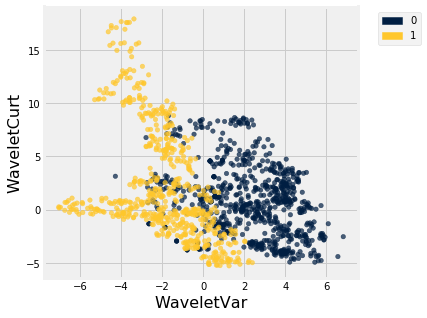

In [28]:
banknotes.scatter('WaveletVar', 'WaveletCurt', colors='Class')

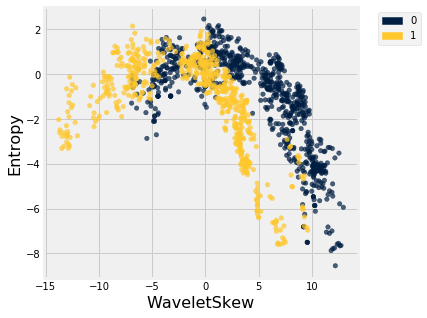

In [29]:
banknotes.scatter('WaveletSkew', 'Entropy', colors='Class')

In [30]:
%matplotlib notebook

In [31]:
fig = plots.figure()
ax = plots.axes(projection='3d')
ax.scatter(banknotes.column('WaveletSkew'), 
           banknotes.column('WaveletVar'), 
           banknotes.column('WaveletCurt'), 
           c=banknotes.column('Class'),
           cmap='viridis',
          s=50);

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
%matplotlib inline

In [33]:
distance(make_array(0,0), make_array(1,1))

1.4142135623730951

In [34]:
distance(make_array(0,0,0), make_array(1,1,1))

1.7320508075688772

In [35]:
distance(make_array(0,0,0,0), make_array(1,1,1,1))

2.0

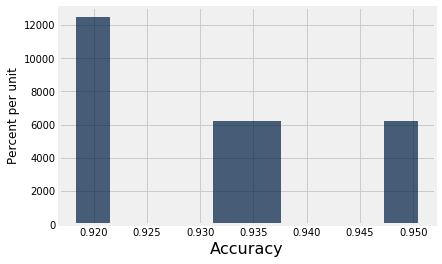

In [36]:
histogram_knn_classifier_accuracy(
    banknotes.select('WaveletVar', 'WaveletSkew', 'Class'), 
    train_knn_su_classifier, k=3)

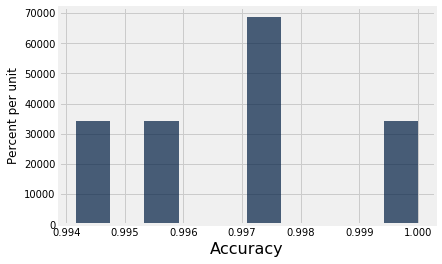

In [37]:
histogram_knn_classifier_accuracy(
    banknotes.select('WaveletVar', 'WaveletSkew', 'WaveletCurt', 'Class'), 
    train_knn_su_classifier, k=3)